In [ ]:
from google.colab import output

!git clone https://github.com/MikhailovBair/EmbeddingComponents.git
!python -m pip install -e ./EmbeddingComponents

!python -m pip install shap datasets
!pip install --upgrade --no-cache-dir gdown
!gdown 1W3eo0VQXxcSjY8kx4IgHGlopd6OK69pp
!unzip probing.zip

!gdown 1PFSpW14aXO-sMNzT_jIjZPfNhk3u3ULD
!unzip probing_numbers.zip

output.clear()

In [ ]:
import gc
import random
import numpy as np
import pickle
from functools import partial
from datasets import load_from_disk
import torch
import torch.nn.functional as F
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
try:
  from senteval.tools.validation import SplitClassifier, SplitClassifier2
except (ImportError, KeyError, ModuleNotFoundError):
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
  print("REQUIRED RELOADING FOR SENTEVAL")
  exit()

SEED = 8
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def prepare_embeds(task_embed):
    X = {'train':  torch.tensor(task_embed['train']['X']),
     'valid':  torch.tensor(task_embed['dev']['X']),
     'test':  torch.tensor(task_embed['test']['X'])}
    y = {'train':  torch.tensor(task_embed['train']['y']),
        'valid':  torch.tensor(task_embed['dev']['y']),
        'test':  torch.tensor(task_embed['test']['y'])}
    sc = StandardScaler()
    X['train'] = torch.tensor(sc.fit_transform(X['train']), dtype=torch.float)
    X['valid'] = torch.tensor(sc.transform(X['valid']), dtype=torch.float)
    X['test'] = torch.tensor(sc.transform(X['test']), dtype=torch.float)
    return X, y


def get_model_weights(task_name, num_epochs, batch_size, lr):
    task_embed = load_from_disk("{}.hf".format(task_name))
    labels = sorted(np.unique(task_embed['train']['y']))
    nclasses = len(dict(zip(labels, range(len(labels)))))
    X, y = prepare_embeds(task_embed)
    train_dataset = torch.utils.data.TensorDataset(X['train'], y['train'])
    val_dataset = torch.utils.data.TensorDataset(X['valid'], y['valid'])
    test_dataset = torch.utils.data.TensorDataset(X['test'], y['test'])

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    model = torch.nn.Linear(X['train'].shape[1], nclasses).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    acs = []
    val_loss = []
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_dataloader:
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        gc.collect()
        current_accuracy = 0
        current_loss = 0
        for X_batch, y_batch in val_dataloader:
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            current_loss += loss.item()
            current_accuracy += (y_pred.to('cpu').argmax(dim=1) == y_batch).sum().item()

        acs.append(current_accuracy / len(val_dataset))
        val_loss.append(current_loss / len(val_dataset))
        if epoch % 20 == 0:
            print(f'epoch: {epoch+1}, Validation accuracy = {acs[-1]:.4f}')

        if len(val_loss) > 10 and val_loss[-1] >= val_loss[-2] and val_loss[-1] >= val_loss[-5]:
            break

    test_accuracy = 0
    test_loss = 0
    for X_batch, y_batch in test_dataloader:
        y_pred = model(X_batch.to(device))
        test_accuracy += (y_pred.to('cpu').argmax(dim=1) == y_batch).sum().item()

    print("Test accuracy {}:".format(task_name), test_accuracy / len(test_dataset))
    plt.plot(acs)
    plt.show()
    plt.plot(val_loss)
    plt.show()
    gc.collect()
    return model.weight.to('cpu').detach().numpy()

In [ ]:
transfer_tasks = [
    'Length',
    'Depth',
    'TopConstituents',
    'BigramShift',
    'Tense',
    'SubjNumber', 'ObjNumber',
    'OddManOut', 'CoordinationInversion',
    'WordContent',
    ]

num_epochs = 200
batch_size = 2048
lr = 0.01

epoch: 1, Validation accuracy = 0.3907
epoch: 21, Validation accuracy = 0.6375
epoch: 41, Validation accuracy = 0.6913
epoch: 61, Validation accuracy = 0.7216
epoch: 81, Validation accuracy = 0.7380
epoch: 101, Validation accuracy = 0.7509
epoch: 121, Validation accuracy = 0.7597
epoch: 141, Validation accuracy = 0.7671
epoch: 161, Validation accuracy = 0.7734
epoch: 181, Validation accuracy = 0.7765
Test accuracy Length: 0.7718087234893958


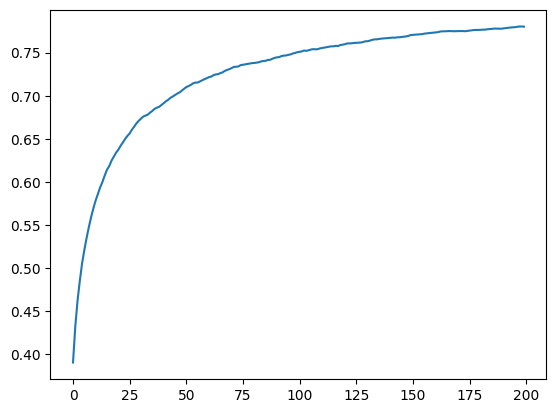

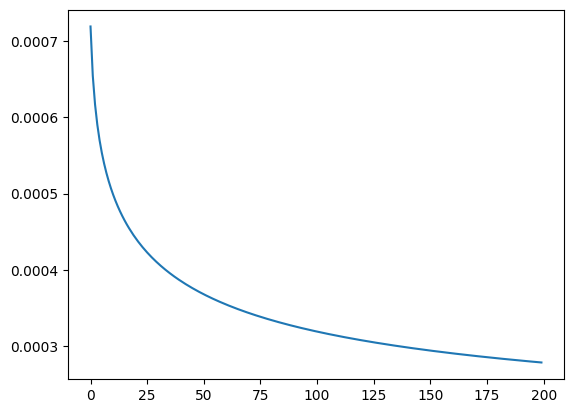

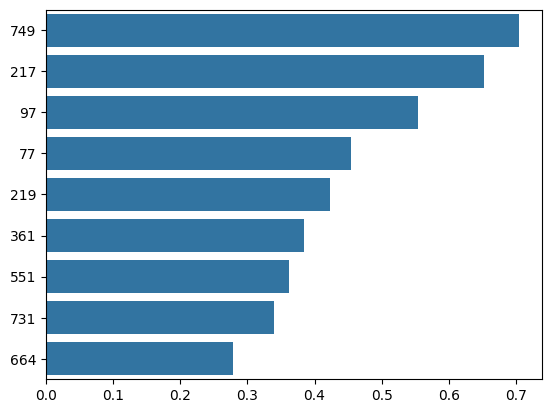

epoch: 1, Validation accuracy = 0.2286
epoch: 21, Validation accuracy = 0.3265
epoch: 41, Validation accuracy = 0.3482
epoch: 61, Validation accuracy = 0.3566
epoch: 81, Validation accuracy = 0.3632
epoch: 101, Validation accuracy = 0.3678
epoch: 121, Validation accuracy = 0.3721
epoch: 141, Validation accuracy = 0.3742
epoch: 161, Validation accuracy = 0.3771
epoch: 181, Validation accuracy = 0.3787
Test accuracy Depth: 0.3835


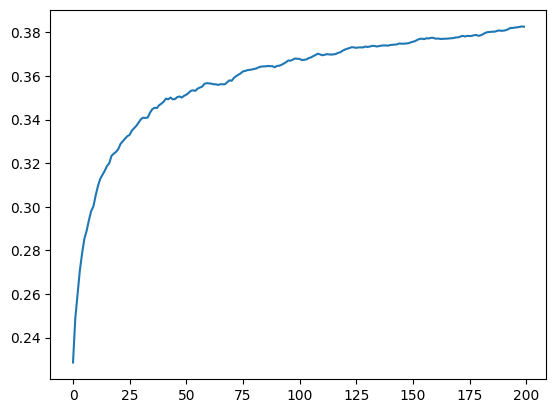

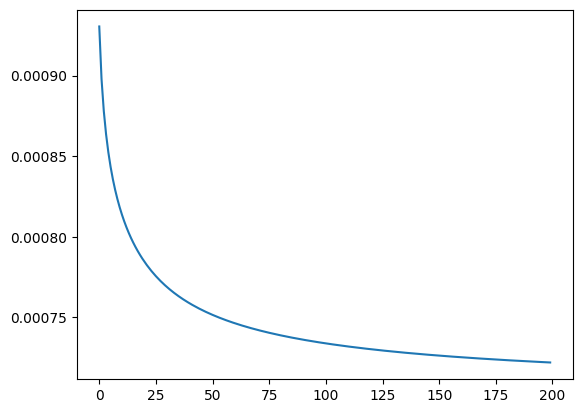

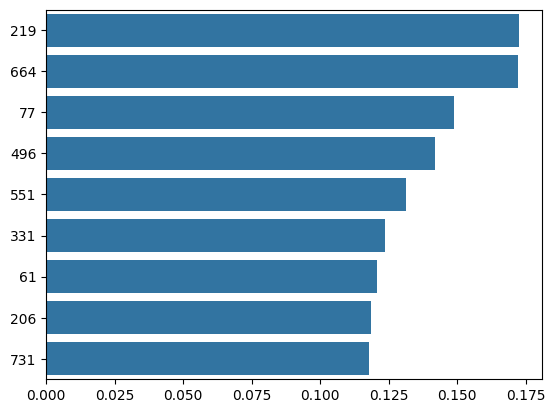

epoch: 1, Validation accuracy = 0.2795
epoch: 21, Validation accuracy = 0.6404
epoch: 41, Validation accuracy = 0.6761
epoch: 61, Validation accuracy = 0.6909
epoch: 81, Validation accuracy = 0.7002
epoch: 101, Validation accuracy = 0.7076
epoch: 121, Validation accuracy = 0.7125
epoch: 141, Validation accuracy = 0.7162
epoch: 161, Validation accuracy = 0.7200
epoch: 181, Validation accuracy = 0.7250
Test accuracy TopConstituents: 0.7252


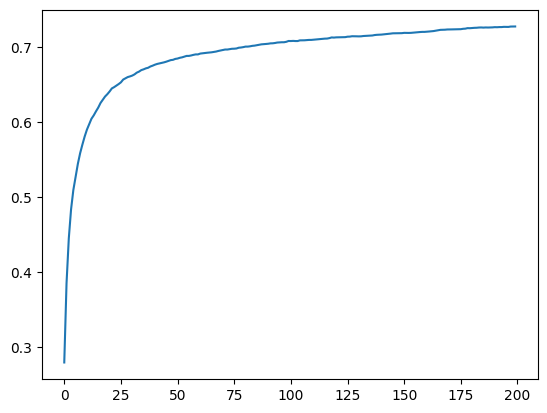

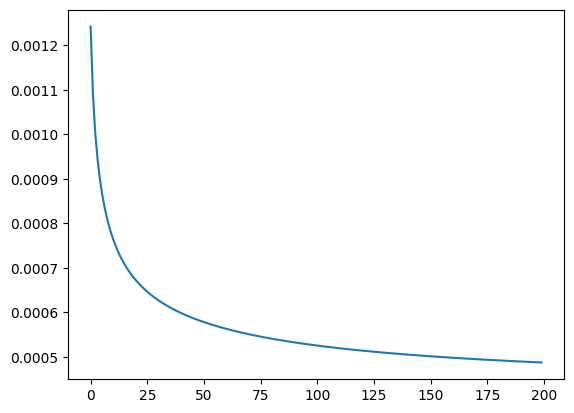

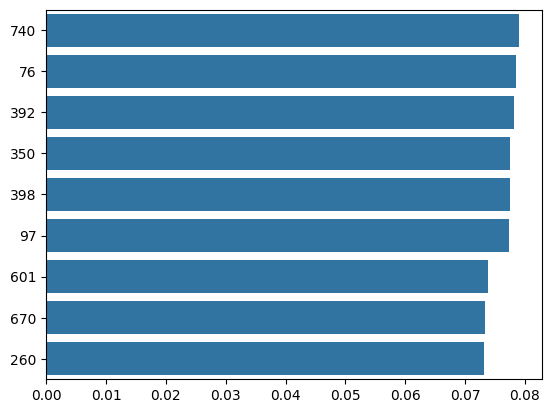

epoch: 1, Validation accuracy = 0.8441
epoch: 21, Validation accuracy = 0.8933
epoch: 41, Validation accuracy = 0.8988
epoch: 61, Validation accuracy = 0.9017
epoch: 81, Validation accuracy = 0.9028
epoch: 101, Validation accuracy = 0.9028
epoch: 121, Validation accuracy = 0.9038
epoch: 141, Validation accuracy = 0.9039
epoch: 161, Validation accuracy = 0.9041
epoch: 181, Validation accuracy = 0.9044
Test accuracy BigramShift: 0.9024


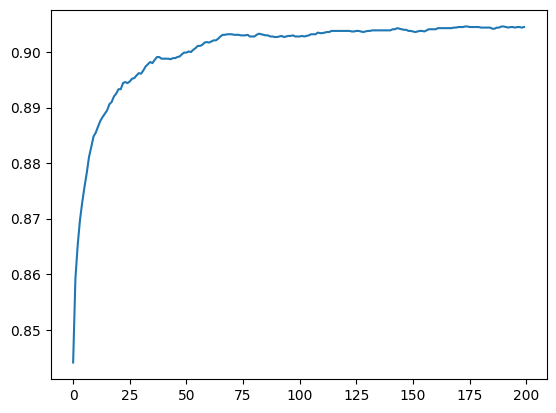

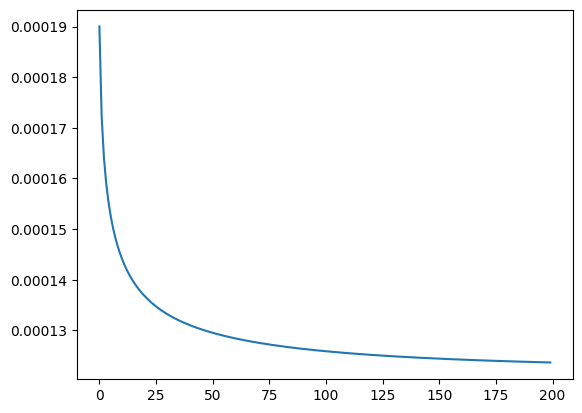

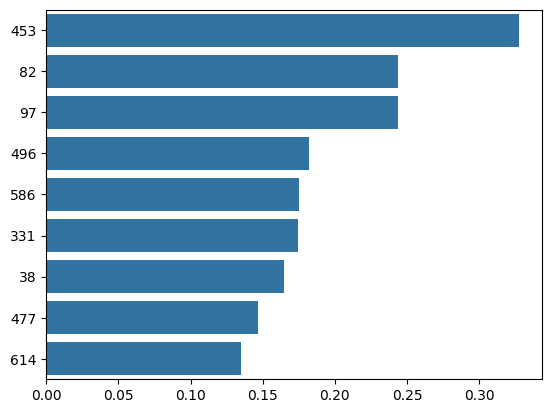

epoch: 1, Validation accuracy = 0.8785
epoch: 21, Validation accuracy = 0.8954
epoch: 41, Validation accuracy = 0.8962
Test accuracy Tense: 0.8829


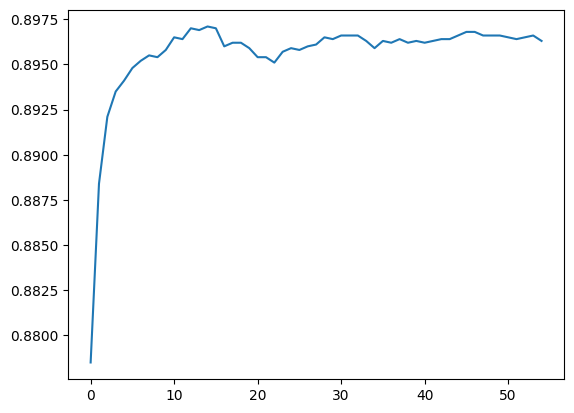

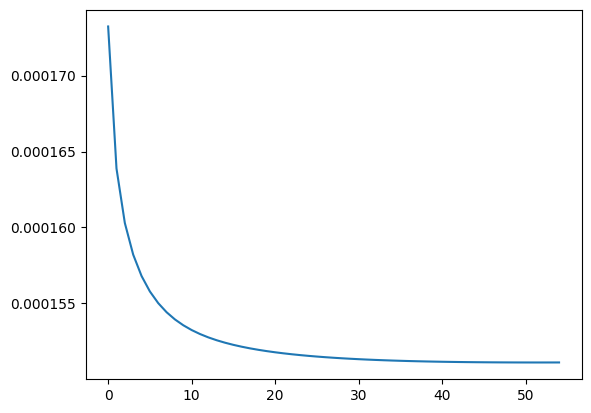

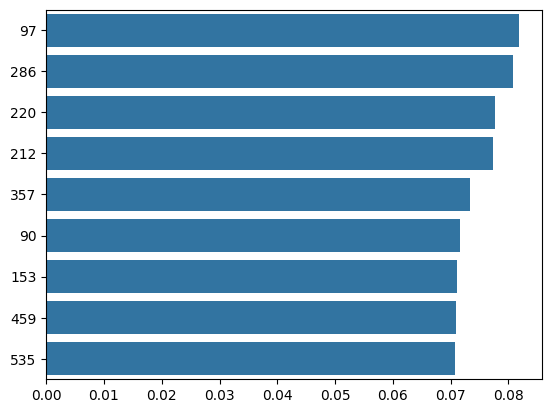

epoch: 1, Validation accuracy = 0.8094
epoch: 21, Validation accuracy = 0.8501
epoch: 41, Validation accuracy = 0.8522
epoch: 61, Validation accuracy = 0.8541
epoch: 81, Validation accuracy = 0.8551
epoch: 101, Validation accuracy = 0.8559
epoch: 121, Validation accuracy = 0.8564
epoch: 141, Validation accuracy = 0.8571
epoch: 161, Validation accuracy = 0.8571
epoch: 181, Validation accuracy = 0.8581
Test accuracy SubjNumber: 0.8543


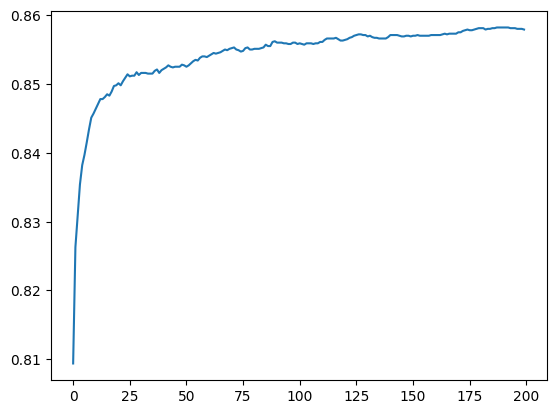

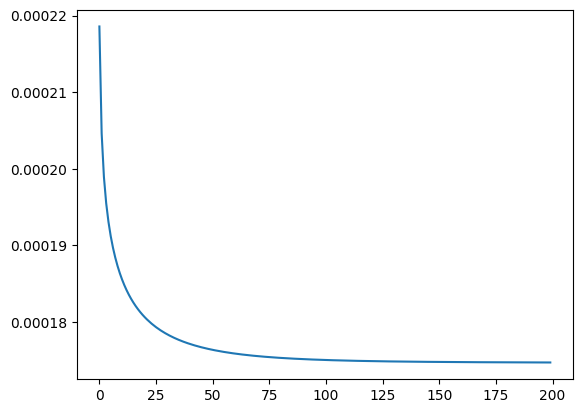

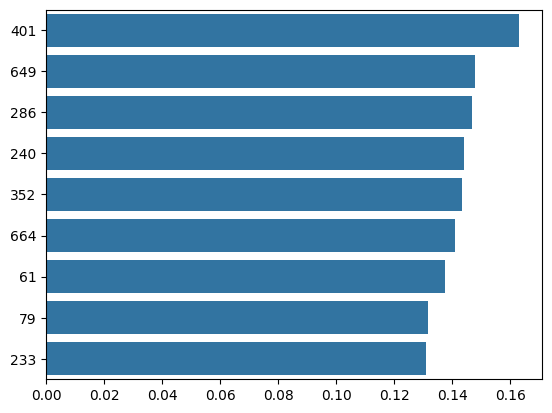

epoch: 1, Validation accuracy = 0.7674
epoch: 21, Validation accuracy = 0.8185
epoch: 41, Validation accuracy = 0.8210
epoch: 61, Validation accuracy = 0.8219
epoch: 81, Validation accuracy = 0.8223
Test accuracy ObjNumber: 0.8307


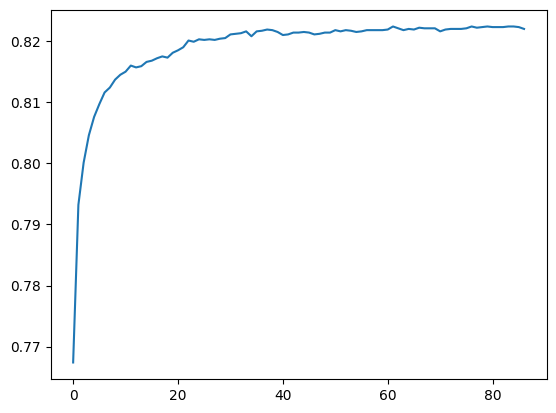

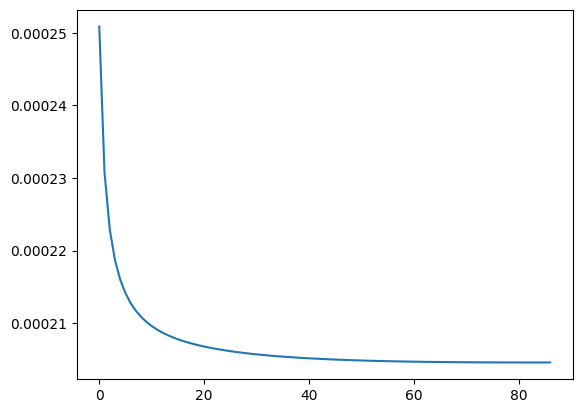

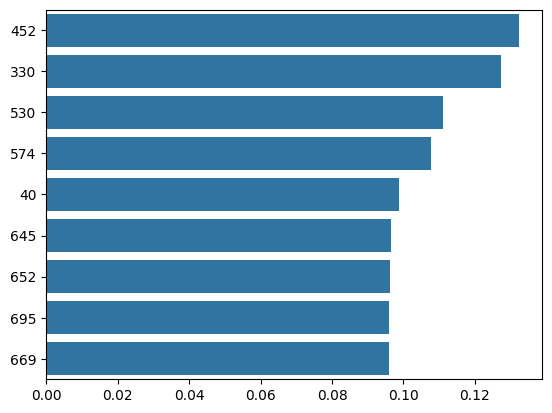

epoch: 1, Validation accuracy = 0.6178
epoch: 21, Validation accuracy = 0.6878
epoch: 41, Validation accuracy = 0.6898
epoch: 61, Validation accuracy = 0.6884
epoch: 81, Validation accuracy = 0.6895
epoch: 101, Validation accuracy = 0.6910
epoch: 121, Validation accuracy = 0.6904
epoch: 141, Validation accuracy = 0.6915
epoch: 161, Validation accuracy = 0.6920
epoch: 181, Validation accuracy = 0.6913
Test accuracy OddManOut: 0.6854


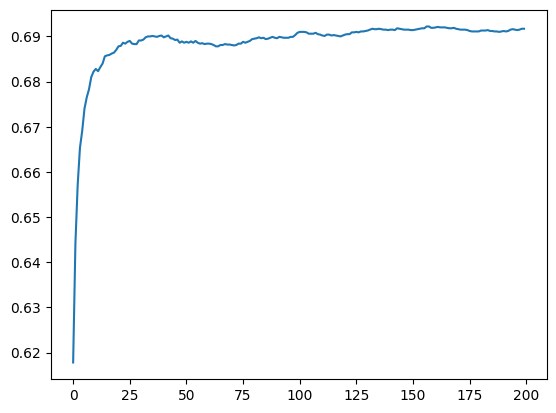

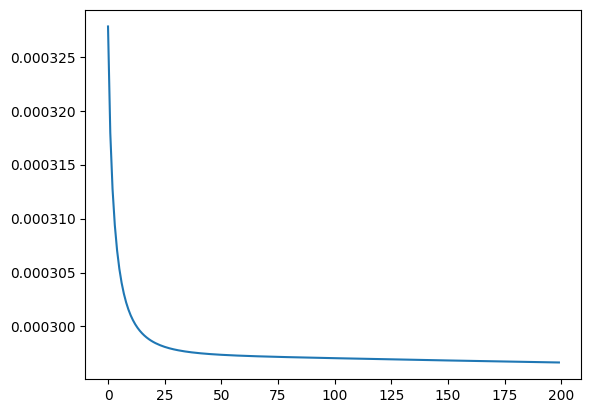

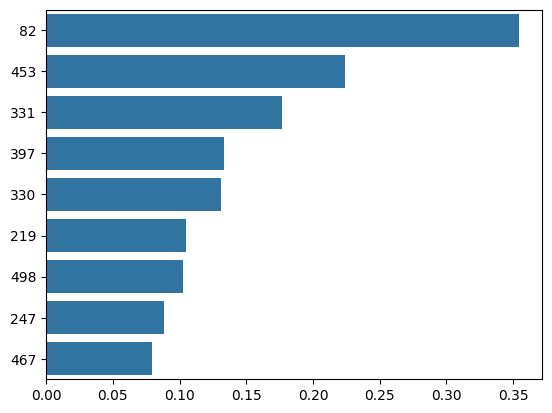

epoch: 1, Validation accuracy = 0.6183
epoch: 21, Validation accuracy = 0.7035
epoch: 41, Validation accuracy = 0.7087
epoch: 61, Validation accuracy = 0.7096
epoch: 81, Validation accuracy = 0.7093
epoch: 101, Validation accuracy = 0.7091
epoch: 121, Validation accuracy = 0.7091
epoch: 141, Validation accuracy = 0.7097
epoch: 161, Validation accuracy = 0.7095
epoch: 181, Validation accuracy = 0.7104
Test accuracy CoordinationInversion: 0.7146570685862828


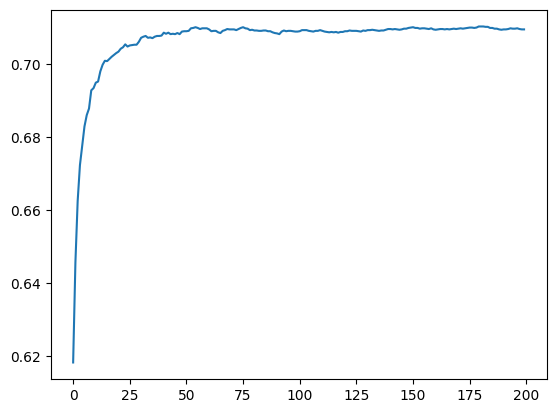

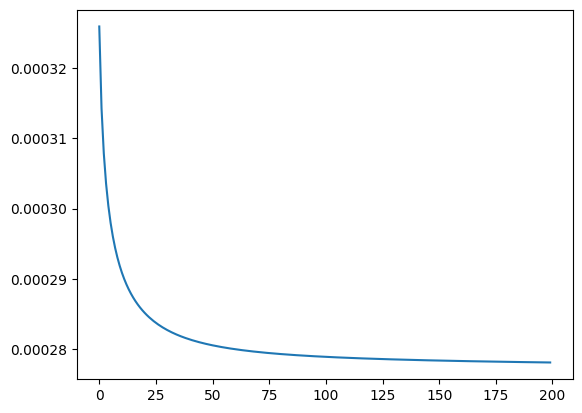

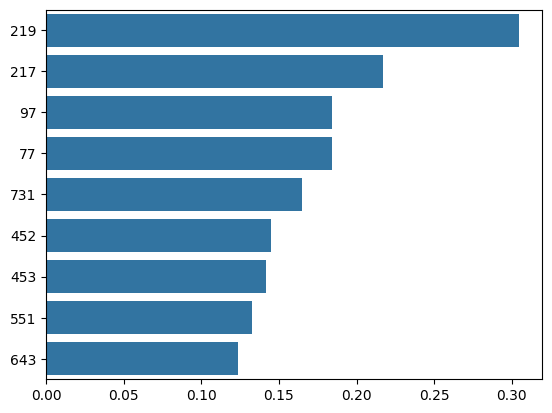

epoch: 1, Validation accuracy = 0.0014
epoch: 21, Validation accuracy = 0.0762
epoch: 41, Validation accuracy = 0.1757
epoch: 61, Validation accuracy = 0.2451
epoch: 81, Validation accuracy = 0.2972
epoch: 101, Validation accuracy = 0.3371
epoch: 121, Validation accuracy = 0.3692
epoch: 141, Validation accuracy = 0.3931
epoch: 161, Validation accuracy = 0.4119
epoch: 181, Validation accuracy = 0.4287
Test accuracy WordContent: 0.4495


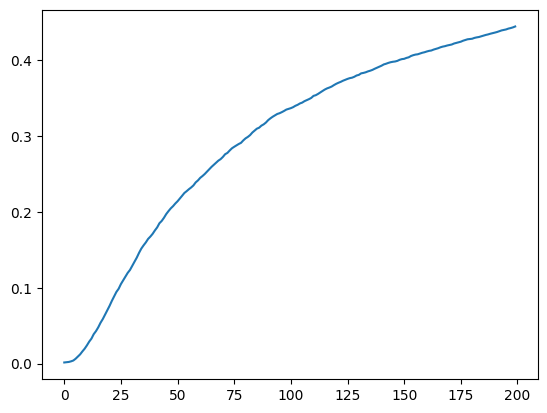

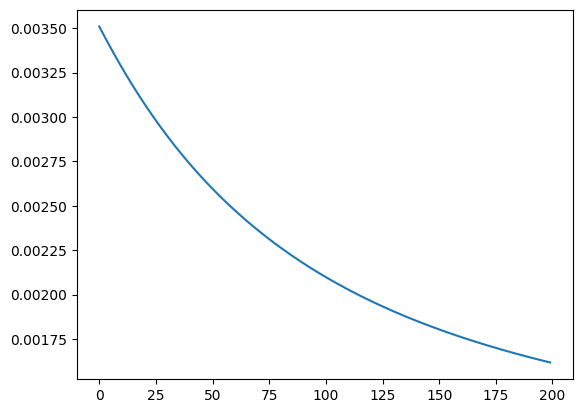

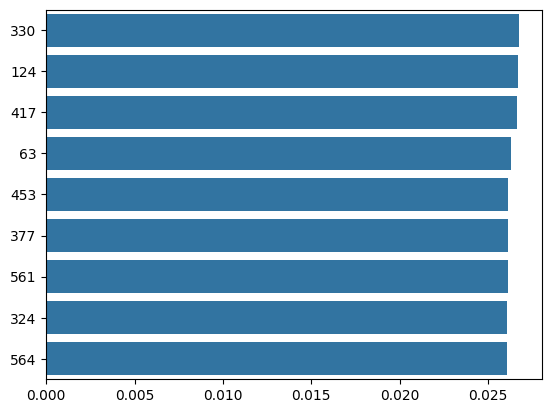

In [ ]:
weights = []
for transfer_task in transfer_tasks:
    weights.append(get_model_weights(transfer_task, num_epochs=num_epochs, batch_size=batch_size, lr=lr))
    best_names = np.abs(weights[-1]).mean(axis=(0)).argsort()[:-10:-1]
    best_values = np.abs(weights[-1]).mean(axis=(0))[best_names]
    best_names = [str(name) for name in best_names]
    sns.barplot(y=best_names, x=best_values, orient="y")
    plt.show()

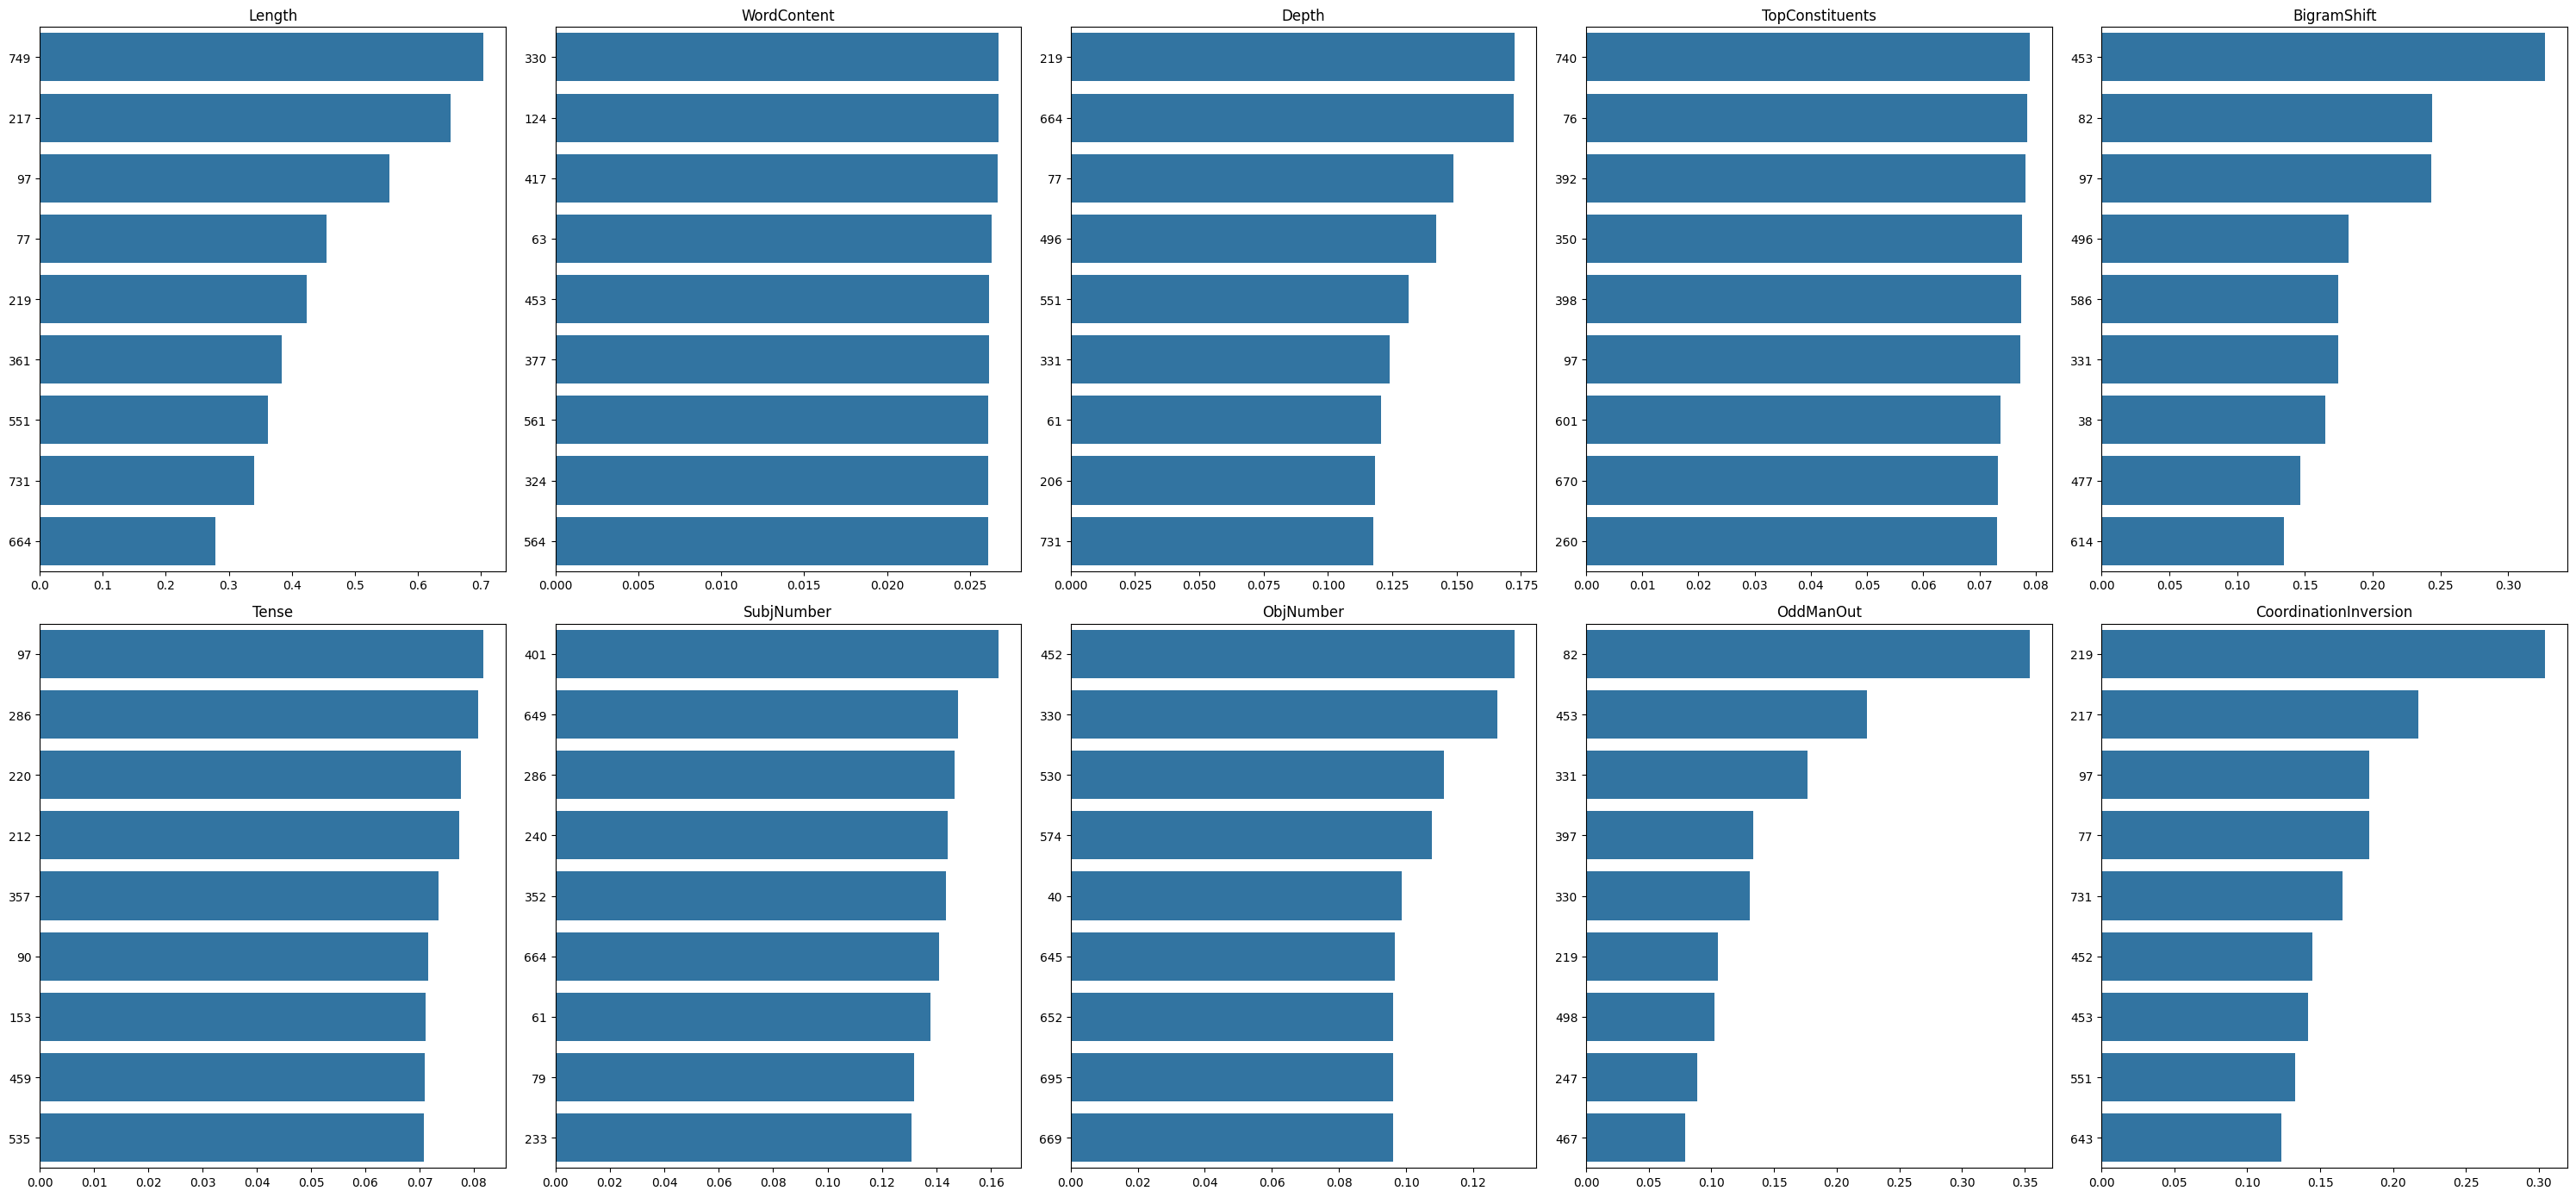

In [ ]:
plt.figure(figsize=(30, 14))
for i, weight in enumerate(weights):
    plt.subplot(2, 5, i + 1)
    best_names = np.abs(weight).mean(axis=(0)).argsort()[:-10:-1]
    best_values = np.abs(weight).mean(axis=(0))[best_names]
    best_names = [str(name) for name in best_names]
    sns.barplot(y=best_names, x=best_values, orient="y")
    plt.title(transfer_tasks[i], )
plt.tight_layout()